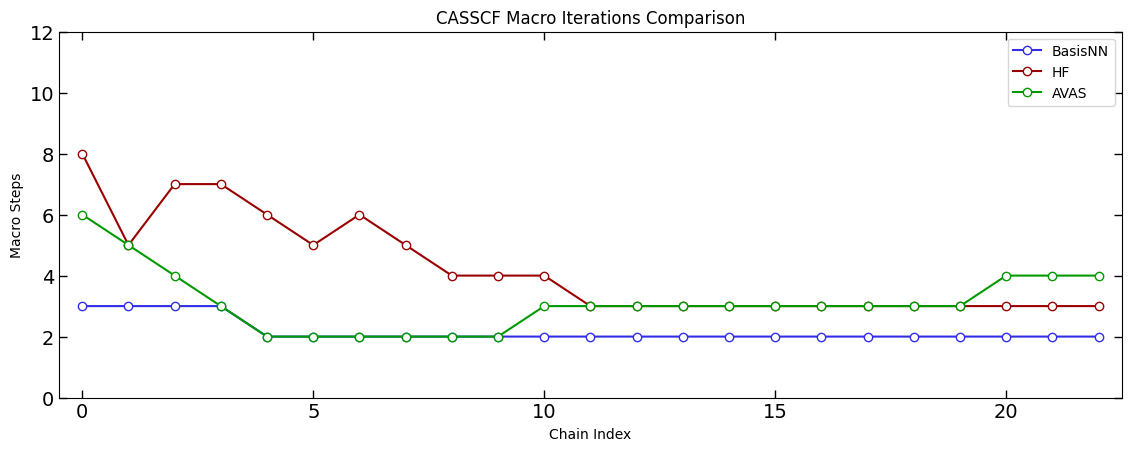

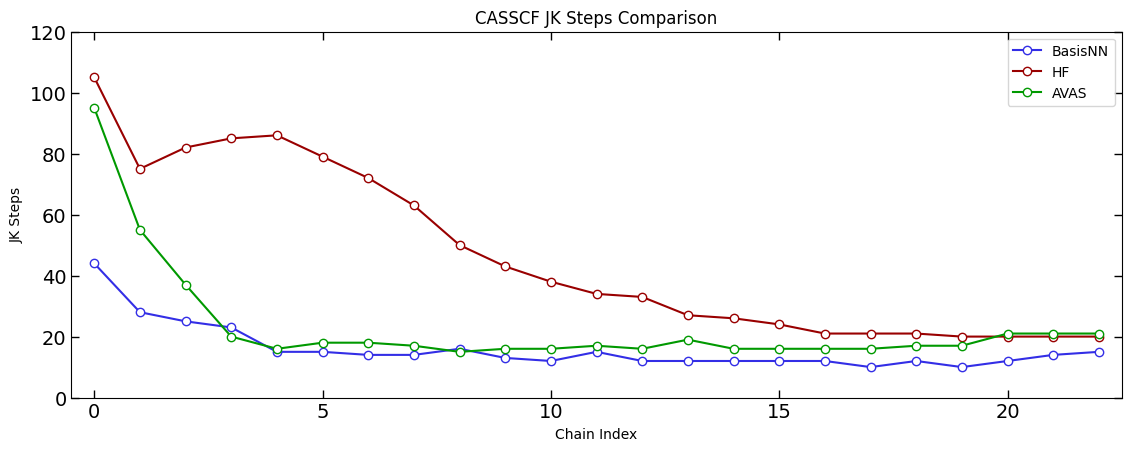

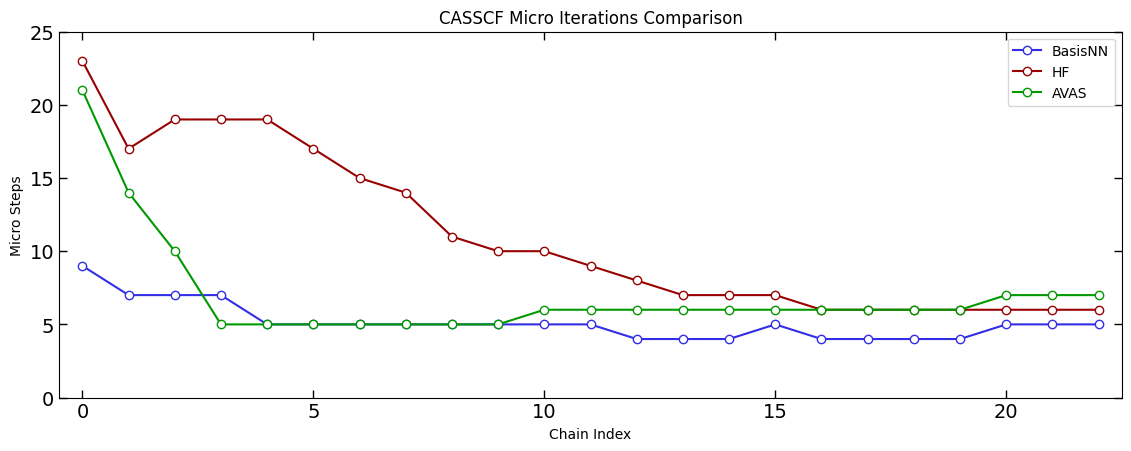

In [6]:
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

# --- Regex patterns ---
pattern_steps = re.compile(r'CASSCF converged in\s+(\d+)\s+macro\s+\(\s*(\d+)\s+JK\s+(\d+)\s+micro')
pattern_energy = re.compile(r'CASSCF energy\s*=\s*([-+]?\d*\.\d+(?:[eE][-+]?\d+)?)')

def extract_number(s):
    m = re.search(r'(\d+)', s)
    return int(m.group(1)) if m else float('inf')

def parse_logs(path, other_label):
    log_files = sorted(glob.glob(f"{path}/log_*.txt"), key=extract_number)
    nn_macro, nn_jk, nn_micro = [], [], []
    other_macro, other_jk, other_micro = [], [], []
    nn_energy, other_energy = [], []

    for log_file in log_files:
        with open(log_file, "r") as f:
            lines = f.readlines()
        matches_steps = [m for line in lines if (m := pattern_steps.search(line))]
        matches_energy = [m for line in lines if (m := pattern_energy.search(line))]
        if len(matches_steps) >= 2 and len(matches_energy) >= 2:
            nn_data = tuple(map(int, matches_steps[0].groups()))
            other_data = tuple(map(int, matches_steps[1].groups()))
            nn_macro.append(nn_data[0])
            nn_jk.append(nn_data[1])
            nn_micro.append(nn_data[2])
            other_macro.append(other_data[0])
            other_jk.append(other_data[1])
            other_micro.append(other_data[2])
            nn_energy.append(float(matches_energy[0].group(1)))
            other_energy.append(float(matches_energy[1].group(1)))
        else:
            print(f"Warning: {log_file} missing matches (Steps: {len(matches_steps)}, Energies: {len(matches_energy)})")

    return {
        "macro": (nn_macro, other_macro),
        "jk": (nn_jk, other_jk),
        "micro": (nn_micro, other_micro),
        "energy": (nn_energy, other_energy),
        "indices": [extract_number(f) for f in log_files]
    }

# --- Parse logs ---
hf_data = parse_logs("cas_init_result", "HF")
avas_data = parse_logs("cas_init_result_avas", "AVAS")

# --- Combine results for plotting ---
# Assuming same indices for both sets (same number of NN chains)
indices = hf_data["indices"]
nn_macro, hf_macro = hf_data["macro"]
nn_jk, hf_jk = hf_data["jk"]
nn_micro, hf_micro = hf_data["micro"]
nn_energy_hf, hf_energy = hf_data["energy"]

nn_macro_a, avas_macro = avas_data["macro"]
nn_jk_a, avas_jk = avas_data["jk"]
nn_micro_a, avas_micro = avas_data["micro"]
nn_energy_avas, avas_energy = avas_data["energy"]

# --- Plot Macro / JK / Micro steps ---
fig_titles = ['Macro Iterations', 'JK Steps', 'Micro Iterations']
nn_data_all = [nn_macro, nn_jk, nn_micro]
hf_data_all = [hf_macro, hf_jk, hf_micro]
avas_data_all = [avas_macro, avas_jk, avas_micro]
ylabels = ['Macro Steps', 'JK Steps', 'Micro Steps']
y_lims = [12, 120, 25]

width_in = 58 / 25.4 * 5
height_in = 23.455 / 25.4 * 5

for i in range(3):
    plt.figure(figsize=(width_in, height_in))
    plt.plot(indices, nn_data_all[i], label='BasisNN', marker='o', markerfacecolor='white', color=(51/255, 46/255, 230/255))
    plt.plot(indices, hf_data_all[i], label='HF', marker='o', markerfacecolor='white', color=(153/255, 0/255, 0/255))
    plt.plot(indices, avas_data_all[i], label='AVAS', marker='o', markerfacecolor='white', color=(0/255, 153/255, 0/255))
    plt.xlabel('Chain Index')
    plt.ylabel(ylabels[i])
    plt.title(f'CASSCF {fig_titles[i]} Comparison')
    plt.legend()
    plt.tick_params(axis='both', direction='in', length=6, width=1, labelsize=14, top=True, right=True)
    plt.xlim(min(indices)-0.5, max(indices)+0.5)
    plt.ylim(0, y_lims[i])
    plt.tight_layout()
    plt.show()


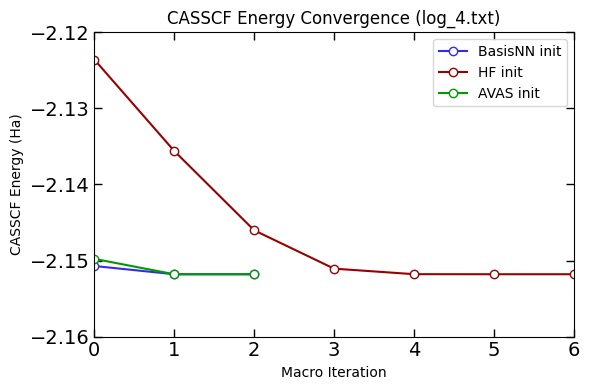

In [12]:
import re
import matplotlib.pyplot as plt

# --- Load log files ---
log_file_hf = "cas_init_result/log_4.txt"
log_file_avas = "cas_init_result_avas/log_4.txt"

# --- Parse NN and HF from HF log ---
with open(log_file_hf, "r") as f:
    lines_hf = f.readlines()

casci_lines_hf = [line for line in lines_hf if "CASCI E" in line]
basisNN_E0_hf = float(re.search(r"CASCI E =\s*(-?\d+\.\d+)", casci_lines_hf[0]).group(1))
hf_E0 = float(re.search(r"CASCI E =\s*(-?\d+\.\d+)", casci_lines_hf[2]).group(1))

macro_pattern = re.compile(r"CASSCF E =\s*(-?\d+\.\d+)")
macro_lines_hf = [line for line in lines_hf if "macro iter" in line]
basisNN_lines_hf = macro_lines_hf[:2]
hf_lines = macro_lines_hf[2:]

basisNN_E_hf = [basisNN_E0_hf] + [float(macro_pattern.search(line).group(1)) for line in basisNN_lines_hf]
hf_E = [hf_E0] + [float(macro_pattern.search(line).group(1)) for line in hf_lines]

# --- Parse NN and AVAS from AVAS log ---
with open(log_file_avas, "r") as f:
    lines_avas = f.readlines()

casci_lines_avas = [line for line in lines_avas if "CASCI E" in line]
basisNN_E0_avas = float(re.search(r"CASCI E =\s*(-?\d+\.\d+)", casci_lines_avas[0]).group(1))
avas_E0 = float(re.search(r"CASCI E =\s*(-?\d+\.\d+)", casci_lines_avas[2]).group(1))

macro_lines_avas = [line for line in lines_avas if "macro iter" in line]
basisNN_lines_avas = macro_lines_avas[:2]
avas_lines = macro_lines_avas[2:]

basisNN_E_avas = [basisNN_E0_avas] + [float(macro_pattern.search(line).group(1)) for line in basisNN_lines_avas]
avas_E = [avas_E0] + [float(macro_pattern.search(line).group(1)) for line in avas_lines]

# --- Plot all three ---
plt.figure(figsize=(6, 4))
plt.plot(range(len(basisNN_E_hf)), basisNN_E_hf, label="BasisNN init", marker='o', markerfacecolor='white', color=(51/255,46/255,230/255))
plt.plot(range(len(hf_E)), hf_E, label="HF init", marker='o', markerfacecolor='white', color=(153/255,0/255,0/255))
plt.plot(range(len(avas_E)), avas_E, label="AVAS init", marker='o', markerfacecolor='white', color=(0/255,153/255,0/255))

plt.xlabel("Macro Iteration")
plt.ylabel("CASSCF Energy (Ha)")
plt.title("CASSCF Energy Convergence (log_4.txt)")
plt.legend()
plt.tick_params(axis='both', direction='in', length=6, width=1, labelsize=14, top=True, right=True)
plt.xlim(0, 6)
plt.ylim(-2.16, -2.12)
plt.tight_layout()
plt.show()
